<a href="https://colab.research.google.com/github/rb1307/U-Net-Based-Approach-for-Segmentation-of-Tables-from-Scanned-Pages/blob/main/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Mix Data 2'

Mounted at /content/drive
/content/drive/My Drive/Mix Data 2


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
X_test=np.zeros([624,256,256,1])
y_test=np.zeros([624,256,256,1])

In [ ]:
for i in range(624):
  img = cv2.imread("X_test/{}.png".format(i),0)
  X_test[i] = 255 - img.reshape(256,256,1)
  
  img = cv2.imread("y_test/{}.png".format(i),0)
  y_test[i] = img.reshape(256,256,1)

In [ ]:
X_test = (X_test-np.mean(X_test))/np.std(X_test)
y_test = y_test/255

In [ ]:
np.sum(y_test)

14769791.560784308

In [ ]:
! pip install keras-unet

In [ ]:
from keras_unet.models import satellite_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
model = satellite_unet(input_shape=(256,256,1), num_layers=5)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth=1
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def loss_f(y_true, y_pred):
  return(1-dice_coef(y_true, y_pred))

In [ ]:
model.compile(optimizer='RMSProp', loss=loss_f, metrics=[dice_coef])

In [ ]:
model.load_weights("model_satellite_1.h5")

In [ ]:
model.evaluate(X_test[:50], y_test[:50])

2/2 [==============================] - 1s 289ms/step - loss: 0.0258 - dice_coef: 0.9704


[0.02577427588403225, 0.9703773260116577]

In [ ]:
model.evaluate(X_test[50:50+170], y_test[50:50+170])

6/6 [==============================] - 2s 290ms/step - loss: 0.0613 - dice_coef: 0.9397


[0.061262186616659164, 0.9397201538085938]

In [ ]:
model.evaluate(X_test[50+170:], y_test[50+170:])

13/13 [==============================] - 4s 324ms/step - loss: 0.0342 - dice_coef: 0.9655


[0.034231074154376984, 0.96550452709198]

In [ ]:
pred_2013 = model.predict(X_test[50:50+170])

In [ ]:
pred_2013.shape

(170, 256, 256, 1)

In [ ]:
pred_2013 = np.round(pred_2013)

In [ ]:
tp = np.sum(y_test[50:50+170].ravel() * pred_2013.ravel()) 
fp = np.sum((1-y_test[50:50+170].ravel()) * pred_2013.ravel())
fn = np.sum(y_test[50:50+170].ravel() * (1-pred_2013.ravel()))

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)

0.9331739264224451 0.9428159098740637


In [ ]:
f = (precision*recall*2)/(precision+recall)

In [ ]:
f

0.9379701398037553

In [ ]:
import matplotlib.pyplot as plt

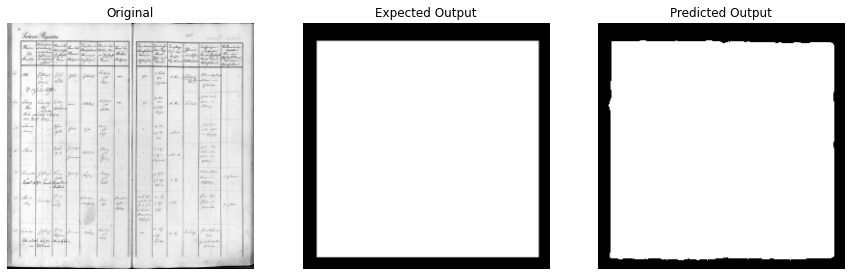

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Original")
plt.imshow(cv2.imread("X_test/{}.png".format(50+170+3),0).reshape(256,256), cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Expected Output")
plt.imshow(y_test[50+170+3].reshape(256,256), cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(model.predict(X_test[50+170+3].reshape(1,256,256,1)).reshape(256,256), cmap='gray')

In [ ]:
def the(img,thesh):
  ret = np.zeros([256,256,1])
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(img[i][j]>thesh):
        ret[i][j]=1
      else:ret[i][j]=0
  return ret

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred.shape

(624, 256, 256, 1)

In [ ]:
test_0 = np.zeros([624,256,256,1])
test_1 = np.zeros([624,256,256,1])
test_2 = np.zeros([624,256,256,1])
test_3 = np.zeros([624,256,256,1])
test_4 = np.zeros([624,256,256,1])

In [ ]:
test_0 = np.copy(pred)
test_0[test_0 > .5] = 1
test_0[test_0 < .5] = 0

In [ ]:
for i in range(624):
  test_0[i] = the(pred[i],0.5)
  test_1[i] = the(pred[i],0.6)
  test_2[i] = the(pred[i],0.7)
  test_3[i] = the(pred[i],0.8)
  test_4[i] = the(pred[i],0.9)

In [ ]:
temp_y = np.copy(y_test)
temp_y[temp_y>0.5]=1
temp_y[temp_y<0.5]=0

In [ ]:
x=temp_y[50+170:].ravel()
x[x>0.5]

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
#0.5
tp = np.sum(temp_y[50+170:].ravel() * test_0[50+170:].ravel()) 
fp = np.sum((1-temp_y[50+170:].ravel()) * test_0[50+170:].ravel())
fn = np.sum(temp_y[50+170:].ravel() * (1-test_0[50+170:].ravel()))
print(tp,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

12541385.0 481514.0 278515.0
0.963025590538635 0.9782747915350354
0.9705902986746906


In [ ]:
#0.6
tp = np.sum(temp_y[50+170:].ravel() * test_1[50+170:].ravel()) 
fp = np.sum((1-temp_y[50+170:].ravel()) * test_1[50+170:].ravel())
fn = np.sum(temp_y[50+170:].ravel() * (1-test_1[50+170:].ravel()))
print(tp,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

12540647.0 480639.0 279253.0
0.9630882080310654 0.9782172247833446
0.9705937645431599


In [ ]:
#0.7
tp = np.sum(temp_y[50+170:].ravel() * test_2[50+170:].ravel()) 
fp = np.sum((1-temp_y[50+170:].ravel()) * test_2[50+170:].ravel())
fn = np.sum(temp_y[50+170:].ravel() * (1-test_2[50+170:].ravel()))
print(tp,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

12539830.0 479610.0 280070.0
0.9631620100403704 0.9781534957370962
0.9705998682628891


In [ ]:
#0.8
tp = np.sum(temp_y[50+170:].ravel() * test_3[50+170:].ravel()) 
fp = np.sum((1-temp_y[50+170:].ravel()) * test_3[50+170:].ravel())
fn = np.sum(temp_y[50+170:].ravel() * (1-test_3[50+170:].ravel()))
print(tp,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

12538865.0 478424.0 281035.0
0.963247032465823 0.9780782221390183
0.9706059742025342


In [ ]:
#0.9
tp = np.sum(temp_y[50+170:].ravel() * test_4[50+170:].ravel()) 
fp = np.sum((1-temp_y[50+170:].ravel()) * test_4[50+170:].ravel())
fn = np.sum(temp_y[50+170:].ravel() * (1-test_4[50+170:].ravel()))
print(tp,fp,fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

12537354.0 476624.0 282546.0
0.9633759946420687 0.9779603585051365
0.9706133937769622


In [ ]:
np.sum([0.9684, 0.9692, 0.9698, 0.9703])/4

0.969425

In [ ]:
tp = np.sum(y_test[50+170:].ravel() * test_0[50+170:].ravel()) 
fp = np.sum((1-y_test[50+170:].ravel()) * test_0[50+170:].ravel())
fn = np.sum(y_test[50+170:].ravel() * (1-test_0[50+170:].ravel()))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

0.9620966729450948 0.9777032482535282
0.9698371795902507


In [ ]:
tp = np.sum(y_test[50+170:].ravel() * test_1[50+170:].ravel()) 
fp = np.sum((1-y_test[50+170:].ravel()) * test_1[50+170:].ravel())
fn = np.sum(y_test[50+170:].ravel() * (1-test_1[50+170:].ravel()))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

0.9621601942132804 0.9776466948288302
0.9698416260733865


In [ ]:
tp = np.sum(y_test[50+170:].ravel() * test_2[50+170:].ravel()) 
fp = np.sum((1-y_test[50+170:].ravel()) * test_2[50+170:].ravel())
fn = np.sum(y_test[50+170:].ravel() * (1-test_2[50+170:].ravel()))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

0.9622348182681393 0.9775839103585889
0.9698486383742534


In [ ]:
tp = np.sum(y_test[50+170:].ravel() * test_3[50+170:].ravel()) 
fp = np.sum((1-y_test[50+170:].ravel()) * test_3[50+170:].ravel())
fn = np.sum(y_test[50+170:].ravel() * (1-test_3[50+170:].ravel()))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

0.9623209877143497 0.9775099288567974
0.9698559933262676


In [ ]:
tp = np.sum(y_test[50+170:].ravel() * test_4[50+170:].ravel()) 
fp = np.sum((1-y_test[50+170:].ravel()) * test_4[50+170:].ravel())
fn = np.sum(y_test[50+170:].ravel() * (1-test_4[50+170:].ravel()))
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(precision,recall)
f = (precision*recall*2)/(precision+recall)
print(f)

0.9624523835139448 0.9773947310176068
0.9698660079498406


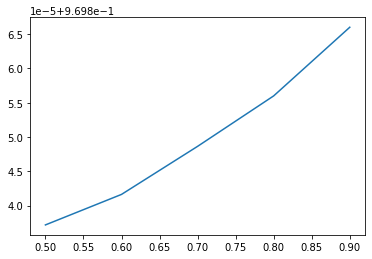

In [ ]:
plt.plot([0.5, 0.6, 0.7, 0.8, 0.9],[0.96983717, 0.96984162, 0.96984863, 0.96985599, 0.96986600])

# Personal Testing

In [ ]:
X_test_p=np.zeros([320,256,256,1])
y_test_p=np.zeros([320,256,256,1])

In [ ]:
! ls

model_satellite_1.h5			 testing	  X_test   y_train
model_satellite_simple.h5		 Testing.ipynb	  X_train
model_satellite_simple_more_training.h5  Untitled0.ipynb  y_test


In [ ]:
for i in range(86):
  img = cv2.imread("testing/X_test/{}.png".format(i),0)
  X_test_p[i] = 255 - img.reshape(256,256,1)
  
  img = cv2.imread("testing/y_test/{}.png".format(i),0)
  y_test_p[i] = img.reshape(256,256,1)

In [ ]:
X_test_p1 = (X_test_p-np.mean(X_test))/np.std(X_test)
X_test_p2 = (X_test_p-np.mean(X_test_p))/np.std(X_test_p)

y_test_p = y_test_p/255

In [ ]:
y_test_p = np.round(y_test_p)

In [ ]:
model.evaluate(X_test_p1[:85], y_test_p[:85])

85/85 [==============================] - 8s 89ms/step


[0.6580161262960995, 0.34198389614329616]

In [ ]:
model.evaluate(X_test_p2[:85], y_test_p[:85])

85/85 [==============================] - 1s 9ms/step


[0.19531937276615816, 0.8046806272338418]

In [ ]:
pred=model.predict(X_test_p2)

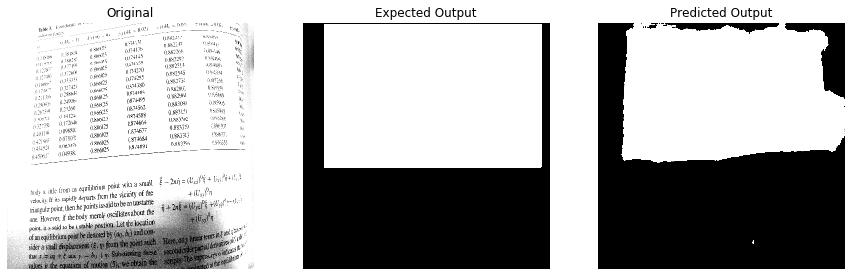

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Original")
plt.imshow(cv2.imread("testing/X_test/{}.png".format(10),0).reshape(256,256), cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Expected Output")
plt.imshow(y_test_p[10].reshape(256,256), cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(model.predict(X_test_p2[10].reshape(1,256,256,1)).reshape(256,256), cmap='gray')

In [ ]:
img = cv2.imread("{}.jpg".format(10),0).reshape(256,256)
#img = (img-np.mean(X_test_p))/np.std(X_test_p)
img = model.predict((img/255).reshape(1,256,256,1))

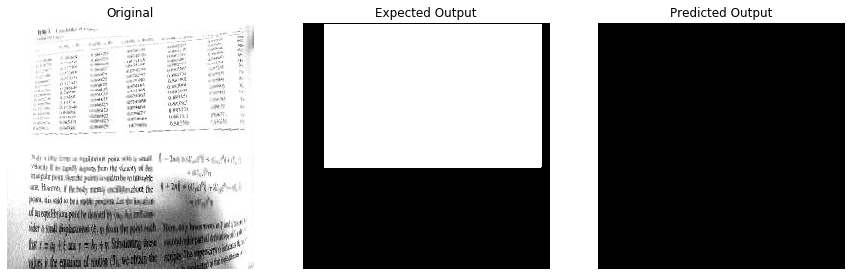

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Original")
plt.imshow(cv2.imread("{}.jpg".format(10),0).reshape(256,256), cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Expected Output")
plt.imshow(y_test_p[10].reshape(256,256), cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(img.reshape(256,256), cmap='gray')

In [ ]:
img = cv2.imread("testing/X_test/{}.png".format(265),0).reshape(256,256)

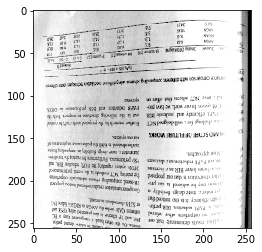

In [ ]:
gamma = 0.5
lookUpTable = np.empty((1,256), np.uint8)
for i in range(256):
  lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(img, lookUpTable)
plt.imshow(res,cmap='gray')

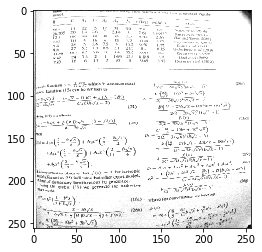

# Testing 2

In [ ]:
X_test_p=np.zeros([7,256,256,1])
y_test_p=np.zeros([7,256,256,1])

In [ ]:
for i in range(1,8):
  img = cv2.imread("distortions/{}.png".format(i),0)
  X_test_p[i-1] = 255 - img.reshape(256,256,1)

In [ ]:
X_test_p = (X_test_p-np.mean(X_test_p))/np.std(X_test_p)

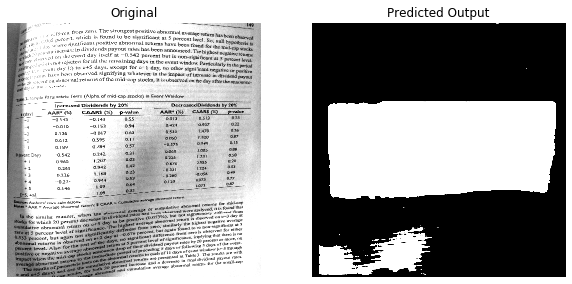

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Original")
plt.imshow(cv2.imread("distortions/{}.png".format(1),0).reshape(256,256), cmap='gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(model.predict(X_test_p[0].reshape(1,256,256,1)).reshape(256,256), cmap='gray')

# New section

# New section

In [ ]:
img = 255-cv2.imread("distortions/corrections/{}.png".format(1),0).reshape(1,256,256,1)
img = (img-np.mean(img))/np.std(img)

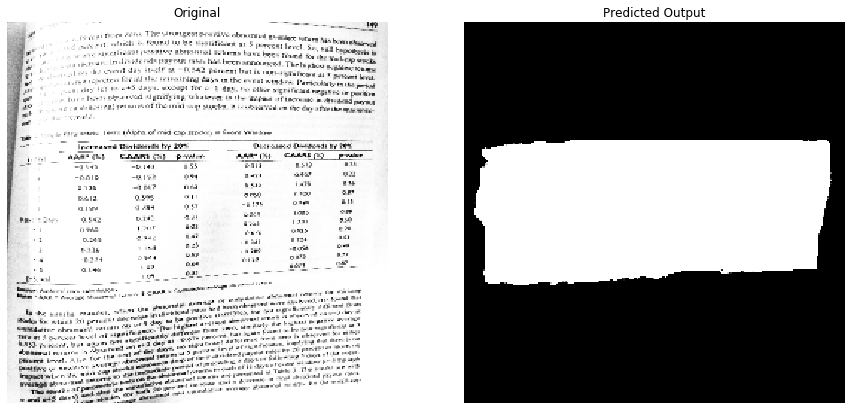

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Original")
plt.imshow(cv2.imread("distortions/corrections/{}.png".format(1),0).reshape(256,256), cmap='gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(model.predict(img).reshape(256,256), cmap='gray')

# Erosion

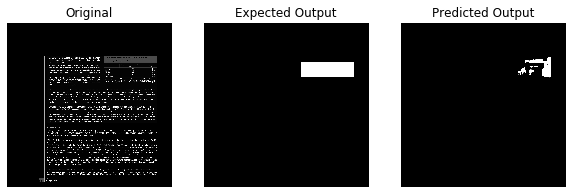

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.axis('off')
plt.title("Original")
plt.imshow(X_test[52].reshape(256,256), cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title("Expected Output")
plt.imshow(y_test[52].reshape(256,256), cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title("Predicted Output")
plt.imshow(model.predict(X_test[52].reshape(1,256,256,1)).reshape(256,256), cmap='gray')

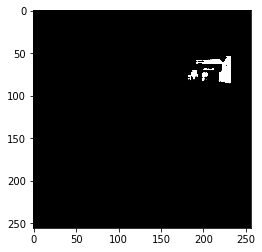

In [ ]:
plt.imshow(model.predict(X_test[52].reshape(1,256,256,1)).reshape(256,256), cmap='gray')

In [ ]:
kernel = np.ones((5,5), np.uint8) 
img_erosion = cv2.erode(model.predict(X_test[52].reshape(1,256,256,1)).reshape(256,256), kernel, iterations=1)

In [ ]:
for i in range(50+170):
  X_test[i+]